In [141]:
# aqui vamos treinar os dados de faturamento do RJ com svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('..')
from Scripts.utils import (train_model_with_grid_search, load_and_predict)

# show all columns 
pd.set_option('display.max_columns', None)
# show entire rows
pd.set_option('display.max_rows', None)
# show all values in a cell
pd.set_option('display.max_colwidth', None)

In [142]:
# carregando os dados
clean_data_rj = pd.read_excel('../Data/clean_data_rj.xlsx')

In [143]:
clean_data_rj.head()

,nome,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,popDe25a49,domiciliosA,domiciliosB,popAte14,domicilios,propDomiciliosCriancas,propDomiciliosIdosos,rendaTotal,rendaMediaPop,propDomiciliosA,propDomiciliosB,propDomiciliosC,propDomiciliosD,propDomiciliosE
0,Abolição,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,932515,Médio,3975,145,1957,1510,4349,0.347206,0.671189,10876849,931.556098,0.033341,0.449989,0.425615,0.021154,0.069901
1,Acari,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931,588833,Baixo,10118,0,588,7319,8451,0.866051,0.283635,7867881,285.440466,0.000000,0.069578,0.536031,0.097858,0.296533
2,Água Santa,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391,874200,Baixo,3831,96,1056,1282,2649,0.483956,0.535674,6333759,703.516495,0.036240,0.398641,0.440166,0.029068,0.095885
3,Alto Da Boa Vista,9606,1072,538,660,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727,912226,Médio,3324,292,910,1610,3154,0.510463,0.629677,11754958,1223.709973,0.092581,0.288523,0.484781,0.043437,0.090679
4,Anchieta,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380,553020,Médio,20932,0,3910,11451,18776,0.609874,0.436195,25910880,452.813254,0.000000,0.208245,0.560929,0.057147,0.173679


In [144]:
clean_data_rj.corr()['faturamento'].abs().sort_values(ascending=False)

/tmp/ipykernel_29786/2389500722.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  clean_data_rj.corr()['faturamento'].abs().sort_values(ascending=False)


faturamento               1.000000
domiciliosA2              0.797492
domiciliosA               0.791605
propDomiciliosC           0.783892
domiciliosA1              0.756939
rendaMediaPop             0.749079
rendaMedia                0.723298
propDomiciliosA           0.723268
rendaTotal                0.710567
domiciliosB1              0.692057
propDomiciliosCriancas    0.688521
propDomiciliosD           0.627032
propDomiciliosB           0.607609
propDomiciliosIdosos      0.603343
propDomiciliosE           0.528512
domiciliosD               0.503628
domiciliosC2              0.468719
domiciliosB               0.464489
domiciliosE               0.390075
popDe10a14                0.358767
popAte14                  0.352955
popAte9                   0.349904
popMaisDe60               0.318009
popDe15a19                0.307270
domiciliosC1              0.291705
popDe20a24                0.228783
popDe25a34                0.130842
domiciliosB2              0.117434
popDe25a49          

In [145]:
# colunas
clean_data_rj.columns

Index(['nome', 'população', 'popAte9', 'popDe10a14', 'popDe15a19',
       'popDe20a24', 'popDe25a34', 'popDe35a49', 'popDe50a59', 'popMaisDe60',
       'domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2',
       'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE',
       'rendaMedia', 'faturamento', 'potencial', 'popDe25a49', 'domiciliosA',
       'domiciliosB', 'popAte14', 'domicilios', 'propDomiciliosCriancas',
       'propDomiciliosIdosos', 'rendaTotal', 'rendaMediaPop',
       'propDomiciliosA', 'propDomiciliosB', 'propDomiciliosC',
       'propDomiciliosD', 'propDomiciliosE'],
      dtype='object')

In [146]:
# drop columns 
clean_data_rj.drop(columns=['nome','potencial'], inplace=True)

In [147]:
# separando os dados em treino e teste
X = clean_data_rj.drop('faturamento', axis=1)
y = clean_data_rj['faturamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

MAE: 56476.94838044893
MSE: 5535195077.603962
RMSE: 74398.8916423085
R2: 0.9318101183267316


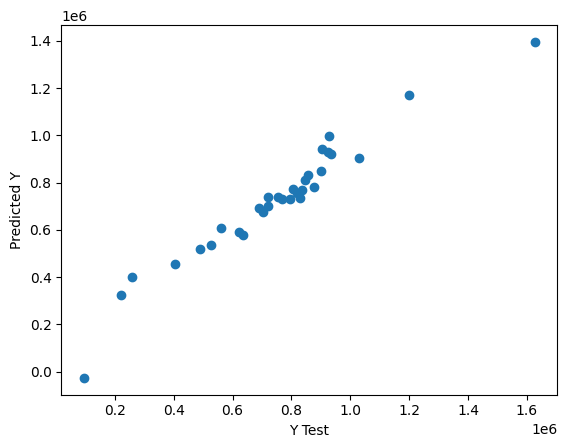

In [148]:
# regressão linear
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

# avaliando o modelo
predictions = lm.predict(X_test)

# plotando os resultados
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

# avaliando o modelo
print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))
print('R2:', r2_score(y_test, predictions))

In [149]:
clean_data_sp = pd.read_excel('../Data/clean_data_sp.xlsx')
clean_data_sp.drop(columns=['nome','potencial'], inplace=True)

X_sp = clean_data_sp.drop('faturamento', axis=1)
lm.predict(scaler.transform(X_sp))

array([ 657371.84299456, 1468727.83024918,  438182.13398512,
       1203995.94203862,  896346.5552514 , 1235607.16899243,
        895084.0569536 , 1613911.98324941, 1288372.40969906,
       1207511.36080814, 1321565.28074211, 1461403.58221453,
        622736.96833535, 1029440.31585191,  929420.58108411,
        842390.02914281, 1337526.40200097,  939370.01100848,
       1437821.92076727, 1116107.40923954, 1266085.71192193,
        970425.92866056, 1441701.19151369,  867981.74907598,
       1401726.70028314,  690758.53314544, 1445677.17080227,
        895811.09002272,  785464.26374177,  733378.73258707,
       1725294.3671314 , 1275456.57340899, 1097436.57188392,
       1030404.41555467, 1364410.32326192, 1084478.73692768,
        862524.34874569,  920596.8299464 ,  968157.38725545,
       1071762.22066116,  760150.39051419,  844209.00613272,
       1358537.60101244, 1221446.46000093, 1130491.12103808,
        918403.93056957,  947808.40314686,  803648.98407201,
        435841.41715982,

In [150]:
X = clean_data_rj.drop('faturamento', axis=1)
y = clean_data_rj['faturamento']

# Definir o modelo
model = SVR()

param_grid = {
    'model__C': [1, 10, 100, 1000, 10000, 12000], 
    'model__gamma': [1, 0.1, 0.01], 
    'model__kernel': ['poly'], 
    'model__epsilon': [0.3, 0.4, 0.5,0.6,0.7], 
    'model__degree': [1, 2], 
    'model__coef0': [0.0, 0.1, 0.2]
    }

# Chamar a função para treinar o modelo com a busca em grade e salvar
train_model_with_grid_search(X, y, model, param_grid, test_size=0.2, random_state=42, save_path='../Models/svr_model_rj.joblib')

Modelo treinado e salvo com sucesso!
Score no conjunto de teste: 0.9191056922168344


In [151]:
# linear regression
model = LinearRegression()

param_grid = {}

# Chamar a função para treinar o modelo com a busca em grade e salvar
train_model_with_grid_search(X, y, model, param_grid, test_size=0.2, random_state=42, save_path='../Models/linear_model_rj.joblib')

Modelo treinado e salvo com sucesso!
Score no conjunto de teste: 0.9318101183267316


In [152]:
load_and_predict(X_sp,'../Models/svr_model_rj.joblib')

array([ 469978.30155625, 1262669.87392279,  254449.24557741,
       1137873.5595497 ,  785630.64768514, 1170924.91676831,
        761134.94069439, 1374769.37747888, 1224087.36876326,
       1142031.01483758, 1331397.3459182 , 1242980.16076166,
        672967.34159522,  913443.09162011,  909621.38665562,
        742097.96418459, 1213649.26653028,  985494.53621509,
       1277113.72506244, 1103070.10484658, 1161659.23073486,
        951739.7503684 , 1305521.95597645,  881464.42375266,
       1203790.62566474,  703102.75705944, 1295686.07212902,
        906974.69328225,  697711.63020796,  798397.38925773,
       1411043.28655816, 1217444.43970306,  842863.37306508,
        964541.08211601, 1282735.73331057,  942627.2129278 ,
        772193.19156634,  863786.06820969,  938590.97503244,
        989783.87658932,  688643.55188287,  865844.36602552,
       1295231.84346424, 1080089.96984241,  912333.17816615,
        892024.80235314,  946830.17681564,  890919.78593525,
        209116.30616515,

In [153]:
load_and_predict(X_sp,'../Models/linear_model_rj.joblib')

array([ 657371.84299456, 1468727.83024918,  438182.13398512,
       1203995.94203862,  896346.5552514 , 1235607.16899243,
        895084.0569536 , 1613911.98324941, 1288372.40969906,
       1207511.36080814, 1321565.28074211, 1461403.58221453,
        622736.96833535, 1029440.31585191,  929420.58108411,
        842390.02914281, 1337526.40200097,  939370.01100848,
       1437821.92076727, 1116107.40923954, 1266085.71192193,
        970425.92866056, 1441701.19151369,  867981.74907598,
       1401726.70028314,  690758.53314544, 1445677.17080227,
        895811.09002272,  785464.26374177,  733378.73258707,
       1725294.3671314 , 1275456.57340899, 1097436.57188392,
       1030404.41555467, 1364410.32326192, 1084478.73692768,
        862524.34874569,  920596.8299464 ,  968157.38725545,
       1071762.22066116,  760150.39051419,  844209.00613272,
       1358537.60101244, 1221446.46000093, 1130491.12103808,
        918403.93056957,  947808.40314686,  803648.98407201,
        435841.41715982,

In [154]:
# using the linear model, create a column with the predicted values
clean_data_sp = pd.read_excel('../Data/clean_data_sp.xlsx').drop(columns=['potencial','faturamento'])
data_to_model_sp = clean_data_sp.drop(columns=['nome'])

clean_data_sp['faturamento'] = load_and_predict(data_to_model_sp,'../Models/linear_model_rj.joblib')

In [155]:
clean_data_sp.head()

,nome,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,popDe25a49,domiciliosA,domiciliosB,popAte14,domicilios,propDomiciliosCriancas,propDomiciliosIdosos,rendaTotal,rendaMediaPop,propDomiciliosA,propDomiciliosB,propDomiciliosC,propDomiciliosD,propDomiciliosE,faturamento
0,A. E. Carvalho,94034,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501,36084,253,6565,19521,28427,0.686706,0.369649,42668927,453.760629,0.008900,0.230942,0.481655,0.079045,0.199458,6.573718e+05
1,Aclimação,32791,2297,1017,2096,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920,12622,3147,6055,3314,13883,0.238709,0.550673,82187360,2506.399927,0.226680,0.436145,0.199741,0.020961,0.116473,1.468728e+06
2,Adventista,104193,15070,7343,10631,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284,41113,0,6298,22413,33862,0.661892,0.289764,43478808,417.291066,0.000000,0.185990,0.551562,0.091873,0.170575,4.381821e+05
3,Água Branca,12721,953,343,627,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278,4975,1291,2590,1296,5645,0.229584,0.569353,35439310,2785.890260,0.228698,0.458813,0.226041,0.014880,0.071568,1.203996e+06
4,Água Funda,48417,5078,2396,4018,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905,18139,303,4780,7474,16065,0.465235,0.533271,30603825,632.088419,0.018861,0.297541,0.455960,0.068721,0.158917,8.963466e+05


In [156]:
# export the data   
clean_data_sp.to_excel('../Data/clean_data_sp_w_revenue.xlsx', index=False)

In [157]:
# create a column with the predicted values
clean_data_rj['faturamento_pred_linear'] = load_and_predict(X,'../Models/linear_model_rj.joblib')
clean_data_rj['faturamento_pred_svr'] = load_and_predict(X,'../Models/svr_model_rj.joblib')

In [158]:
# show first 10 rows of fatuamento and faturamento_pred
clean_data_rj['erro_percentage_linear'] = (clean_data_rj['faturamento'] - clean_data_rj['faturamento_pred_linear'])*100/clean_data_rj['faturamento']
clean_data_rj['erro_percentage_svr'] = (clean_data_rj['faturamento'] - clean_data_rj['faturamento_pred_svr'])*100/clean_data_rj['faturamento']
# show rows with erro_percentage > 10 or erro_percentage_svr > 10
clean_data_rj[(clean_data_rj['erro_percentage_linear'] > 10) | (clean_data_rj['erro_percentage_svr'] > 10)]

,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,popDe25a49,domiciliosA,domiciliosB,popAte14,domicilios,propDomiciliosCriancas,propDomiciliosIdosos,rendaTotal,rendaMediaPop,propDomiciliosA,propDomiciliosB,propDomiciliosC,propDomiciliosD,propDomiciliosE,faturamento_pred_linear,faturamento_pred_svr,erro_percentage_linear,erro_percentage_svr
7,249987,32651,15949,20926,20146,37750,53090,31246,38229,0,496,5246,13274,24363,22447,4564,11109,1550,35465,90840,496,18520,48600,81499,0.596326,0.469073,126323450,505.320077,0.006086,0.227242,0.574363,0.056001,0.136308,4.003985e+03,3.546497e+04,88.710039,0.000098
14,85229,6278,2608,4410,5911,14697,18262,12026,21037,3669,5165,11669,6106,5289,3009,371,1853,8316,2211985,32959,8834,17775,8886,37131,0.239315,0.566562,308781396,3622.961621,0.237914,0.478711,0.223479,0.009992,0.049904,2.152164e+06,1.843768e+06,2.704392,16.646451
19,2025,282,120,155,175,460,452,207,174,4,52,144,104,132,132,35,92,2929,876113,912,56,248,402,695,0.578417,0.250360,2035655,1005.261728,0.080576,0.356835,0.379856,0.050360,0.132374,7.800260e+05,8.325779e+05,10.967417,4.969117
47,51456,2612,1241,2044,3049,8071,9582,7426,17431,3253,3648,7334,4041,3677,1434,184,986,10619,1981817,17653,6901,11375,3853,24557,0.156900,0.709818,260770783,5067.840155,0.281020,0.463208,0.208128,0.007493,0.040151,1.907600e+06,1.762536e+06,3.744916,11.064662
51,18215,2493,1176,1521,1667,3465,4188,1868,1837,32,66,286,788,2065,2199,414,540,1837,641865,7653,98,1074,3669,6390,0.574178,0.287480,11738430,644.437551,0.015336,0.168075,0.667293,0.064789,0.084507,5.666670e+05,6.312068e+05,11.715544,1.660497
65,99102,9633,4743,6564,6855,14400,20477,14384,22046,0,636,4874,8325,10129,6948,1222,3103,2140,1030856,34877,636,13199,14376,35237,0.407980,0.625649,75407180,760.904724,0.018049,0.374578,0.484633,0.034679,0.088061,9.040788e+05,9.007614e+05,12.298244,12.620055
67,161748,24961,10376,13874,16321,32572,35693,14500,13451,422,1244,3405,7984,17034,15909,3178,6837,2160,94671,68265,1666,11389,35337,56013,0.630871,0.240141,120988080,748.003561,0.029743,0.203328,0.588131,0.056737,0.122061,-2.617015e+04,1.760617e+05,127.643260,-85.972182
75,46839,3463,1529,2340,2814,7145,9917,6877,12754,2423,3297,5831,3467,3029,1180,118,557,8980,1762798,17062,5720,9298,4992,19902,0.250829,0.640840,178719960,3815.622878,0.287408,0.467189,0.211486,0.005929,0.027987,1.714164e+06,1.565686e+06,2.758915,11.181747
76,47342,3134,1380,2131,2390,6177,9519,7181,15430,5423,3532,5342,1863,1890,917,217,1595,14738,2119774,15696,8955,7205,4514,20779,0.217239,0.742577,306240902,6468.693803,0.430964,0.346744,0.135088,0.010443,0.076760,2.152435e+06,1.844140e+06,-1.540768,13.002982
79,51520,5608,2812,3753,3907,7548,10437,7068,10387,0,110,1747,4124,5487,3566,834,2032,1848,835847,17985,110,5871,8420,17900,0.470391,0.580279,33079200,642.065217,0.006145,0.327989,0.505754,0.046592,0.113520,7.299343e+05,7.960472e+05,12.671308,4.761619


In [159]:
len(clean_data_rj[(clean_data_rj['erro_percentage_linear'] > 10)])/len(clean_data_rj)

0.07236842105263158

In [160]:
len(clean_data_rj[(clean_data_rj['erro_percentage_svr'] > 10)])/len(clean_data_rj)

0.06578947368421052